In [1]:
!pip install nltk -q


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split


2025-07-20 23:18:17.589985: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753053497.774029      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753053497.831687      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:

import csv, re
import pandas as pd
import string
import numpy as np


INPUT_TSV  = "/kaggle/input/pratikshasarma40abc/pratikshasarma40.tsv"
OUTPUT_TSV = "/kaggle/working/pratikshasarma40.cleaned.tsv"



ENG_LETTER_RE     = re.compile(r"[A-Za-z]")
DEV_START, DEV_END = 0x0900, 0x097F
ANGLE_RE          = re.compile(r"[<>]")
REPEATED_PUNCT_RE = re.compile(r'([!"#\$%&\'\(\)\*\+,\-./:;<=>\?@\[\]\\\^_`{\|}~])\1{5,}')
HTML_TAG_RE       = re.compile(r"<\s*[^>]+>")
SHAPE_RE          = re.compile(r"[\u25A0-\u25FF]")
EMOJI_RE          = re.compile(
    r"[\U0001F300-\U0001F5FF"
    r"\U0001F600-\U0001F64F"
    r"\U0001F680-\U0001F6FF"
    r"\U0001F900-\U0001F9FF]"
)
REPEATED_NUM_RE   = re.compile(r"(?:\d+)(?:\D+\d+){5,}")
BRACKET_NUM_RE    = re.compile(r"(?:\[\d+\])(?:\s*\[\d+\]){5,}")
REPEATED_WORD_RE  = re.compile(r"\b(\w+)(?:[,\s]+\1){2,}", re.IGNORECASE)
REPEATED_PHRASE_RE= re.compile(r"\b(.{3,}?)\s+\1\s+\1", re.IGNORECASE)

def has_english(s):      return bool(ENG_LETTER_RE.search(s))
def count_deva(s):       return sum(DEV_START <= ord(ch) <= DEV_END for ch in s)
def has_hindi(s):        return count_deva(s) >= 2
def has_angle(s):        return bool(ANGLE_RE.search(s))
def has_rep_punct(s):    return bool(REPEATED_PUNCT_RE.search(s))
def has_html(s):         return bool(HTML_TAG_RE.search(s))
def has_shape(s):        return bool(SHAPE_RE.search(s))
def has_emoji(s):        return bool(EMOJI_RE.search(s))
def has_rep_num(s):      return bool(REPEATED_NUM_RE.search(s) or BRACKET_NUM_RE.search(s))
def has_rep_word(s):     return bool(REPEATED_WORD_RE.search(s))
def has_rep_phrase(s):   return bool(REPEATED_PHRASE_RE.search(s))
def is_empty(s):         return (s is None) or (not s.strip())

counts = {
    "total": 0,
    "empty_src": 0, "empty_tgt": 0,
    "bad_src_eng": 0, "bad_src_hindi": 0, "bad_tgt_hindi": 0,
    "angle": 0, "html": 0, "rep_punct": 0, "rep_punct_tgt": 0,
    "shape": 0, "emoji": 0, "rep_num": 0, "rep_word": 0, "rep_phrase": 0,
}

filtered_rows = []

with open(INPUT_TSV, encoding="utf-8", newline="") as fin:
    reader = csv.reader(fin, delimiter="\t")
    for row in reader:
        counts["total"] += 1
        if len(row) < 2:
            continue
        src, tgt = row[0], row[1]

        if is_empty(src):
            counts["empty_src"] += 1; continue
        if is_empty(tgt):
            counts["empty_tgt"] += 1; continue
        if has_english(src):
            counts["bad_src_eng"] += 1; continue
        if has_hindi(src):
            counts["bad_src_hindi"] += 1; continue
        if has_hindi(tgt):
            counts["bad_tgt_hindi"] += 1; continue
        if has_angle(src) or has_angle(tgt):
            counts["angle"] += 1; continue
        if has_html(src) or has_html(tgt):
            counts["html"] += 1; continue
        if has_rep_punct(src):
            counts["rep_punct"] += 1; continue
        if has_rep_punct(tgt):
            counts["rep_punct_tgt"] += 1; continue
        if has_shape(src) or has_shape(tgt):
            counts["shape"] += 1; continue
        if has_emoji(src) or has_emoji(tgt):
            counts["emoji"] += 1; continue
        if has_rep_num(src) or has_rep_num(tgt):
            counts["rep_num"] += 1; continue
        if has_rep_word(src) or has_rep_word(tgt):
            counts["rep_word"] += 1; continue
        if has_rep_phrase(tgt):
            counts["rep_phrase"] += 1; continue

        filtered_rows.append((src, tgt))

kept = counts["total"] - sum(v for k, v in counts.items() if k != "total")
print(f"✅ Cleaned Rows Kept: {kept} / {counts['total']}")

# Save filtered rows to intermediate TS
with open(OUTPUT_TSV, "w", encoding="utf-8", newline="") as fout:
    writer = csv.writer(fout, delimiter="\t")
    writer.writerows(filtered_rows)


df = pd.read_csv(OUTPUT_TSV, sep="\t", names=["assamese", "english"])

df['english'] = df['english'].astype(str).str.lower().str.replace(f"[{string.punctuation}]", "", regex=True)
df['english'] = df['english'].str.replace(r'\s+', ' ', regex=True).str.strip()
df['assamese'] = df['assamese'].astype(str).str.replace(r'\s+', ' ', regex=True).str.strip()

# Remove empty strings
df = df[(df['english'] != '') & (df['assamese'] != '')]

# Remove rows with only digits or symbols
def is_only_symbols_or_digits(text):
    return bool(re.fullmatch(r'[\d\s@#$%^&*()_+={}[\]\\|;:\'",<>./?!-]*', text))

df = df[~df['english'].apply(is_only_symbols_or_digits)]
df = df[~df['assamese'].apply(is_only_symbols_or_digits)]

# Sentence length between 3 and 50
df = df[df['english'].str.split().apply(len).between(3, 50)]
df = df[df['assamese'].str.split().apply(len).between(3, 50)]

# Remove duplicates
df.drop_duplicates(subset=['english', 'assamese'], inplace=True)
df.reset_index(drop=True, inplace=True)

# Add start/end tokens
df['english'] = 'startseq ' + df['english'] + ' endseq'
df['assamese'] = 'startseq ' + df['assamese'] + ' endseq'

# ✅ Final Preview
print("✅ Final cleaned data (first 5 rows):")
print(df.head())
df.to_csv("/kaggle/working/cleaned_dataset.tsv", sep="\t", index=False)
# ✅ Final Preview
print("✅ Final cleaned data (first 5 rows):")
print(df.head())

# Save to cleaned_dataset.tsv with column headers
df.to_csv("/kaggle/working/cleaned_dataset.tsv", sep="\t", index=False, header=True)


✅ Cleaned Rows Kept: 9596 / 10001
✅ Final cleaned data (first 5 rows):
                                            assamese  \
0  startseq তদুপৰি এইবেলিও পূৰ্বৰ দৰেই তেওঁ বিপুল...   
1  startseq ১৯৮৫ বেটছৰ আই পি এছ বিষয়া আছিল কুলধৰ ...   
2  startseq প্ৰতিবছৰৰ দৰে এইবাৰো বহাগ মাহৰ কৃষ্ণ ...   
3  startseq ইছৰ’ৰ অধ্যক্ষৰ পৰা এই বিজুতিৰ বিষয়ে অ...   
4  startseq বৃহস্পতিবাৰে ঘোষণা হ’ব লগা লোকসভা নিৰ...   

                                             english  
0  startseq moreover naba kumar sarania has expre...  
1  startseq kuladhar saikia was an ips officer of...  
2  startseq like every year this time too the 55t...  
3  startseq the moment he came to know about the ...  
4  startseq this is how the laddu is preparing fo...  
✅ Final cleaned data (first 5 rows):
                                            assamese  \
0  startseq তদুপৰি এইবেলিও পূৰ্বৰ দৰেই তেওঁ বিপুল...   
1  startseq ১৯৮৫ বেটছৰ আই পি এছ বিষয়া আছিল কুলধৰ ...   
2  startseq প্ৰতিবছৰৰ দৰে এইবাৰো বহাগ মাহৰ কৃষ্ণ ...   
3

In [4]:
df = pd.read_csv("/kaggle/working/cleaned_dataset.tsv", sep="\t")


In [5]:
tokenizer_eng = Tokenizer()
tokenizer_ass = Tokenizer()

tokenizer_eng.fit_on_texts(df['english'])
tokenizer_ass.fit_on_texts(df['assamese'])

sequences_eng = tokenizer_eng.texts_to_sequences(df['english'])
sequences_ass = tokenizer_ass.texts_to_sequences(df['assamese'])


english_vocab_size = len(tokenizer_eng.word_index) + 1
assamese_vocab_size = len(tokenizer_ass.word_index) + 1

print(f"English Vocab Size: {english_vocab_size}")
print(f"Assamese Vocab Size: {assamese_vocab_size}")
print(len(sequences_eng))
print(len(sequences_ass))



English Vocab Size: 16249
Assamese Vocab Size: 29236
9324
9324


In [6]:
eng_length = 50
ass_length = 51


encoder_input = pad_sequences(sequences_eng, maxlen=50, padding='post')
decoder_output = pad_sequences(sequences_ass, maxlen=51, padding='post')


X_train_enc, X_val_enc, decoder_output_train, decoder_output_val = train_test_split(
    encoder_input, decoder_output, test_size=0.1, random_state=42)

X_train_dec = decoder_output_train[:, :-1]
X_val_dec = decoder_output_val[:, :-1]


y_train = decoder_output_train[:, 1:]  
y_val = np.expand_dims(decoder_output_val[:, 1:], -1)

y_train = np.expand_dims(y_train, -1)

In [7]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, TimeDistributed
from tensorflow.keras.models import Model
import tensorflow as tf


class MaskedAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(MaskedAttention, self).__init__(**kwargs)

    def call(self, inputs, mask=None):
        attention_scores = tf.matmul(inputs, inputs, transpose_b=True)
        
        if mask is not None:
            mask = tf.cast(mask, dtype=attention_scores.dtype)
            mask = tf.expand_dims(mask, axis=1)  
            attention_scores += (1.0 - mask) * -1e9

        attention_weights = tf.nn.softmax(attention_scores, axis=-1)
        context = tf.matmul(attention_weights, inputs)
        return context

    def compute_mask(self, inputs, mask=None):
        
        return None  
    
def masked_loss(y_true, y_pred):
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    mask = tf.cast(tf.not_equal(y_true, 0), dtype=loss.dtype)
    loss = loss * mask  # Zero out the loss where y_true == 0 
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)
    

encoder_inputs = Input(shape=(eng_length,))
encoder_embedding = Embedding(input_dim=english_vocab_size, output_dim=256, mask_zero=True)(encoder_inputs)
encoder_lstm, state_h, state_c = LSTM(512, return_sequences=True, return_state=True)(encoder_embedding)
encoder_lstm = Dropout(0.3)(encoder_lstm)  # try 0.3 or 0.5

decoder_inputs = Input(shape=(50,))
decoder_embedding = Embedding(input_dim=assamese_vocab_size, output_dim=256, mask_zero=True)(decoder_inputs)
decoder_lstm, _, _ = LSTM(512, return_sequences=True, return_state=True)(decoder_embedding, initial_state=[state_h, state_c])


attention_output = MaskedAttention()(decoder_lstm)


decoder_dense = TimeDistributed(Dense(assamese_vocab_size, activation='softmax'))
decoder_outputs = decoder_dense(attention_output)


model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss=masked_loss, metrics=['accuracy'])
model.summary()

print(attention_output.shape)
print(decoder_inputs.shape)
print(decoder_outputs.shape)



I0000 00:00:1753053512.054587      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 50, 256)   │  4,159,744 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 50)        │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 50, 256)   │  7,484,416 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 50, 512), │  1,574,912 │ embedding[0][0],  │
│                     │ (None, 512),      │            │ not_equal[0][0]   │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 50, 512), │  1,574,912 │ embedding_1[0][0… │
│                     │ (None, 512),      │            │ lstm[0][1],       │
│                     │ (None, 512)]      │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 50)        │          0 │ input_layer_1[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masked_attention    │ (None, 50, 512)   │          0 │ lstm_1[0][0],     │
│ (MaskedAttention)   │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 50, 29236) │ 14,998,068 │ masked_attention… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 29,792,052 (113.65 MB)

 Trainable params: 29,792,052 (113.65 MB)

 Non-trainable params: 0 (0.00 B)

(None, 50, 512)
(None, 50)
(None, 50, 29236)


In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1)


checkpoint = ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

# Compile the model with Adam optimizer
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    [X_train_enc, X_train_dec],
    y_train,  
    validation_data=([X_val_enc, X_val_dec], y_val),
    epochs=60,
    batch_size=64,
    callbacks=[early_stopping,]
)


Epoch 1/60


I0000 00:00:1753053521.676524     101 cuda_dnn.cc:529] Loaded cuDNN version 90300


132/132 ━━━━━━━━━━━━━━━━━━━━ 41s 233ms/step - accuracy: 0.6614 - loss: 4.9722 - val_accuracy: 0.6931 - val_loss: 3.0047
Epoch 2/60
132/132 ━━━━━━━━━━━━━━━━━━━━ 29s 222ms/step - accuracy: 0.6941 - loss: 2.9021 - val_accuracy: 0.6938 - val_loss: 2.9121
Epoch 3/60
132/132 ━━━━━━━━━━━━━━━━━━━━ 29s 222ms/step - accuracy: 0.6938 - loss: 2.7845 - val_accuracy: 0.7055 - val_loss: 2.8310
Epoch 4/60
132/132 ━━━━━━━━━━━━━━━━━━━━ 29s 222ms/step - accuracy: 0.7082 - loss: 2.6681 - val_accuracy: 0.7154 - val_loss: 2.7310
Epoch 5/60
132/132 ━━━━━━━━━━━━━━━━━━━━ 29s 222ms/step - accuracy: 0.7154 - loss: 2.5704 - val_accuracy: 0.7191 - val_loss: 2.6010
Epoch 6/60
132/132 ━━━━━━━━━━━━━━━━━━━━ 29s 222ms/step - accuracy: 0.7191 - loss: 2.4315 - val_accuracy: 0.7222 - val_loss: 2.5519
Epoch 7/60
132/132 ━━━━━━━━━━━━━━━━━━━━ 29s 222ms/step - accuracy: 0.7239 - loss: 2.3200 - val_accuracy: 0.7275 - val_loss: 2.5112
Epoch 8/60
132/132 ━━━━━━━━━━━━━━━━━━━━ 29s 222ms/step - accuracy: 0.7329 - loss: 2.2226 - val

In [9]:
import pickle
from tensorflow.keras.models import Model


model.save("english_assamese_translation_model.h5")



with open("tokenizer_eng.pkl", "wb") as f:
    pickle.dump(tokenizer_eng, f)

with open("tokenizer_ass.pkl", "wb") as f:
    pickle.dump(tokenizer_ass, f)

print(" Models and tokenizers saved successfully.")


✅ Models and tokenizers saved successfully.


In [26]:

model.save("english_assamese_translation_model.keras", save_format="keras")


In [10]:

!pip install sacrebleu -q

import numpy as np
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import sacrebleu


reverse_assamese_word_index = {v: k for k, v in tokenizer_ass.word_index.items()}

def decode_sequence(seq):
    return ' '.join([reverse_assamese_word_index.get(idx, '') for idx in seq if idx != 0])


smoothie = SmoothingFunction().method4
total_bleu = 0


all_references = []
all_predictions = []

for i in range(len(X_val_enc)):
    
    enc_input = X_val_enc[i:i+1]
    dec_input = X_val_dec[i:i+1]

    
    prediction = model.predict([enc_input, dec_input], verbose=0)
    pred_seq = np.argmax(prediction, axis=-1)[0]

    
    reference_sentence = decode_sequence(y_val[i].squeeze())
    predicted_sentence = decode_sequence(pred_seq)

    
    reference_clean = reference_sentence.replace('startseq', '').replace('endseq', '').strip()
    prediction_clean = predicted_sentence.replace('startseq', '').replace('endseq', '').strip()

    reference = [reference_clean.split()]
    candidate = prediction_clean.split()

    
    bleu_score = sentence_bleu(reference, candidate, smoothing_function=smoothie)
    total_bleu += bleu_score

    
    all_references.append(reference_clean)
    all_predictions.append(prediction_clean)

    
    print(f"\n🔹 Sentence {i+1}")
    print(f"   Ground Truth: {reference_clean}")
    print(f"   Prediction  : {prediction_clean}")
    print(f"   BLEU Score  : {bleu_score:.4f}")


avg_bleu = total_bleu / len(X_val_enc)
print(f"\n📊 Average BLEU Score (NLTK): {avg_bleu:.4f}")


sacrebleu_bleu = sacrebleu.corpus_bleu(all_predictions, [all_references])
sacrebleu_chrf = sacrebleu.corpus_chrf(all_predictions, [all_references])
sacrebleu_ter = sacrebleu.corpus_ter(all_predictions, [all_references])

print("\n📈 SacreBLEU Corpus Scores:")
print(f"   BLEU:  {sacrebleu_bleu.score:.4f}")
print(f"   CHRF:  {sacrebleu_chrf.score:.4f}")
print(f"   TER:   {sacrebleu_ter.score:.4f}")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 1.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 5.3 MB/s eta 0:00:00

🔹 Sentence 1
  ✅ Ground Truth: দৈনিক শ শ ট্ৰাক ডাম্পাৰে সেইসমূহ সংৰক্ষিত স্থানৰ পৰা অবৈধভাৱে বালি কঢ়িয়াই আছে।
  🤖 Prediction  : এই বছৰৰ বছৰৰ বছৰৰ এই এই এই পৰা পৰা পৰা যাতনা
  🔵 BLEU Score  : 0.0180

🔹 Sentence 2
  ✅ Ground Truth: ৰাজ্যপালৰ শাসন প্ৰযোজ্য হব নেকি সোমবাৰে ম্যাদ সমাপ্ত হব বি টি চি পৰিষদৰ
  🤖 Prediction  : এই পাছতে কালত নাই নাই যে এই ভৰ্তি হ’ল কৰিলে চি চি চি
  🔵 BLEU Score  : 0.0187

🔹 Sentence 3
  ✅ Ground Truth: এই আইনে কোনো নাগৰিকৰ ক্ষতি নকৰে বুলিও মন্তব্য কৰে তেওঁ।
  🤖 Prediction  : এই এই কোনো কোনো এই বুলিও বুলিও বুলিও কৰে কৰে
  🔵 BLEU Score  : 0.0332

🔹 Sentence 4
  ✅ Ground Truth: উত্থাপিত অভিযোগ অনুসৰি মেৰামতিৰ নামত ধার্য কৰা এই বৃহৎ পৰিমাণৰ ধনেৰে বিভাগীয় বিষয়া–কর্মচাৰী ঠিকাদাৰ আৰু ৰাজনৈতিক প্রভাৱশালী লোকে নিজৰ জেপ গধুৰ কৰাৰ বিপৰীতে খাটিখোৱা কৃষক জনতা উপকৃত হোৱা নাই৷
  🤖 Prediction  : মতে মতে অভিযোগ এই

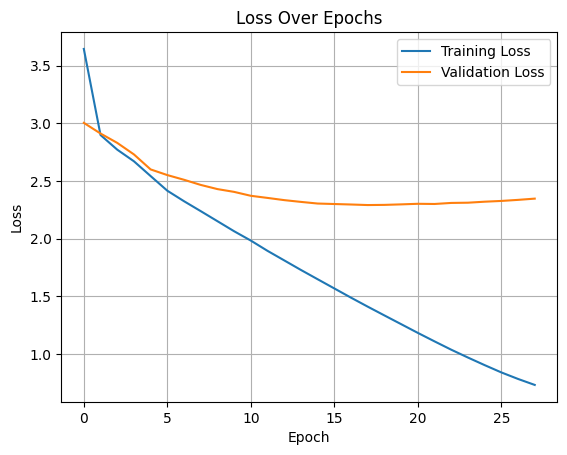

In [11]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [27]:
import numpy as np
import pickle
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load custom loss & attention class (redefine here)
class MaskedAttention(tf.keras.layers.Layer):
    def call(self, inputs, mask=None):
        attention_scores = tf.matmul(inputs, inputs, transpose_b=True)
        if mask is not None:
            mask = tf.cast(mask, dtype=attention_scores.dtype)
            mask = tf.expand_dims(mask, axis=1)
            attention_scores += (1.0 - mask) * -1e9
        attention_weights = tf.nn.softmax(attention_scores, axis=-1)
        context = tf.matmul(attention_weights, inputs)
        return context

def masked_loss(y_true, y_pred):
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    mask = tf.cast(tf.not_equal(y_true, 0), dtype=loss.dtype)
    loss *= mask
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)

# Load model from .keras
model = load_model(
    "english_assamese_translation_model.keras",
    custom_objects={
        "MaskedAttention": MaskedAttention,
        "masked_loss": masked_loss
    },
    compile=False
)

# Load tokenizers
with open("tokenizer_eng.pkl", "rb") as f:
    tokenizer_eng = pickle.load(f)
with open("tokenizer_ass.pkl", "rb") as f:
    tokenizer_ass = pickle.load(f)

reverse_assamese_word_index = {v: k for k, v in tokenizer_ass.word_index.items()}
eng_length, ass_length = 50, 50

# Translation function
def translate(input_text):
    input_seq = tokenizer_eng.texts_to_sequences([input_text.lower()])
    input_seq = pad_sequences(input_seq, maxlen=eng_length, padding='post')

    target_seq = np.zeros((1, ass_length))
    target_seq[0, 0] = tokenizer_ass.word_index.get('startseq', 1)

    translation = ''
    for i in range(1, ass_length):
        preds = model.predict([input_seq, target_seq], verbose=0)
        pred_token = np.argmax(preds[0, i - 1, :])
        word = reverse_assamese_word_index.get(pred_token, '')
        if word == 'endseq' or word == '':
            break
        translation += word + ' '
        target_seq[0, i] = pred_token

    return translation.strip()

# Try it
input_text = input("Enter English sentence: ")
print("Assamese Translation:", translate(input_text))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'masked_attention' (of type MaskedAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Enter English sentence:  MY NAME IS PRATIKSHA


Assamese Translation: প্ৰেৰক
